# Qiskit QML - categorizing the MNIST dataset

Starting with imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
)
import torch.nn.functional as F

Loading the dataset for the training part, filtering to only work with 0 and 1

In [2]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

Plotting the images:

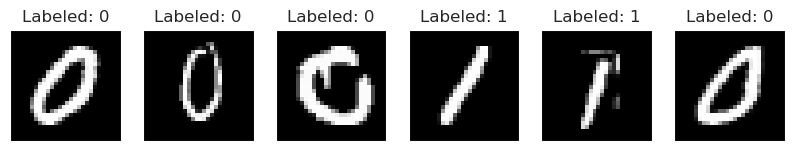

In [3]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1


Now loading the test dataset, again filtering to work with 0 and 1 only

In [4]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

Creating our quantum neural network

In [5]:

# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

Defining our Torch NN module:

In [6]:
from qiskit_machine_learning.connectors import TorchConnector


# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)


Training the NN:

In [7]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))



Training [10%]	Loss: -1.1630
Training [20%]	Loss: -1.5294
Training [30%]	Loss: -1.7855
Training [40%]	Loss: -1.9863
Training [50%]	Loss: -2.2257
Training [60%]	Loss: -2.4513
Training [70%]	Loss: -2.6758
Training [80%]	Loss: -2.8832
Training [90%]	Loss: -3.1006
Training [100%]	Loss: -3.3061


Plotting loss convergence:

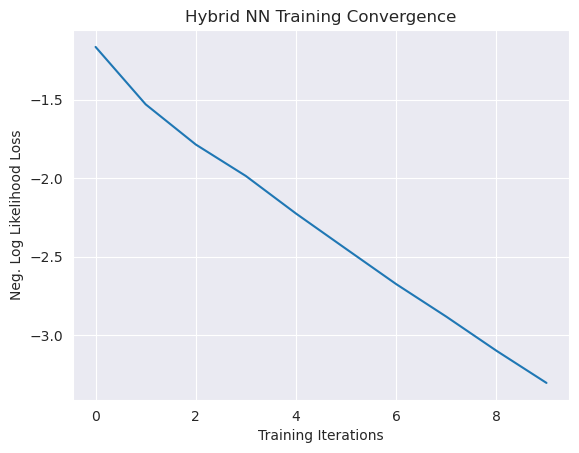

In [8]:

# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()



In [9]:
torch.save(model4.state_dict(), "model4.pt")

In [10]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [11]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -3.3585
	Accuracy: 100.0%


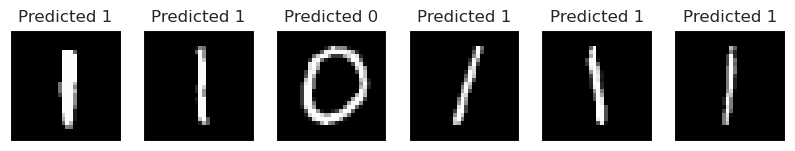

In [12]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

